Packages used:
    1. Numpy for numerical operations
    2. Pillow (PIL) for Image opening
    3. os for file path operations
    4. glob for additional file path operations

In [2]:
import numpy as np
from collections import Counter
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt

First importing images. For this I'm assuming defined path for MNIST dataset, assuming this project file is adjacent to MNIST folder. Structure should look like
```bash
PROJECT/
├── MNIST/
│   ├── 0/
│   ├── 1/
│   └── ...etc/
└── Solution/
    └── project1.ipynb
```

I can not gaurentee correct data importation if that structure is not maintained.

Function load_mnist_data() will use the ../MNIST folder to populate images and labels. Since the data was binned in folders 0-9 we can use os.path.join with the digit as string.


Glob will return a list of every .png in digit folders. Then loop will open with pillows Image.open applying [.convert('L')](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert) to convert to grayscale. Once images and labels populated returns as numpy array. This function takes around 2s on my desktop and 8s on my laptop.

In [3]:
mnist_path = '../MNIST'

def load_mnist_data():
    """Load MNIST data from the folder structure"""
    images = []
    labels = []
    
    # Iterate through each digit folder (0-9)
    for digit in range(10):
        digit_folder = os.path.join(mnist_path, str(digit))
        if os.path.exists(digit_folder):
            # Get all PNG files in the digit folder
            image_files = glob.glob(os.path.join(digit_folder, '*.png'))
            
            for image_file in image_files:
                # Load and convert image to grayscale
                img = Image.open(image_file).convert('L')
                # Convert to numpy array and flatten
                img_array = np.array(img)
                
                images.append(img_array)
                labels.append(digit)
    
    return np.array(images), np.array(labels)

images, labels = load_mnist_data()
print(f"Loaded {len(images)} images with shape {images[0].shape}")

Loaded 60000 images with shape (28, 28)


To clean up data flatten all 60000 of the 28,28 images to quickly normalize, np.reshape('samplecount',-1), creates 60000,784 matrix. 

In [20]:
# Flatten images for normalization
num_samples = images.shape[0] 
images_flat = images.reshape(num_samples,-1) 

Normalizing pixel values to [0,1]. We can use Min-Max scaling formula:


$$ 
X_{norm} = \frac{X-X_{min}}{X_{max}-X_{min}}
$$

In [32]:
def normalize(X):
    X_min = X.min(axis=1, keepdims=True)
    X_max = X.max(axis=1, keepdims=True)
    X_normalized = (X - X_min) / (X_max - X_min)
    return X_normalized
    

In [35]:
images_normalized_flat = normalize(images_flat)

images_normalized = images_normalized_flat.reshape(num_samples,28,28) #Reshape back to original shape

print(f"Min value: {images_normalized_flat.min()}, Max value: {images_normalized_flat.max()}")

Min value: 0.0, Max value: 1.0


Now we need to split the data into training and testing sets. We'll create a custom train_test_split function that:
1. Shuffles the data randomly (if shuffle=True)
2. Splits based on train_size proportion

In [36]:
def train_test_split(X, y, train_size=0.75, test_size=0.25, shuffle=True, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    #Assert train_size + test_size == 1.0
    assert abs((train_size + test_size) - 1.0) < 1e-6, "train_size and test_size must sum to 1.0"
    
    n_train = int(n_samples * train_size)
    
    train_indices = indices[:n_train]
    test_indices = indices[n_train:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

For first run we will split data with 75-25 train-test split from our flattened normalized images.

In [38]:
x_train, x_test, y_train, y_test = train_test_split(images_normalized_flat, labels, shuffle=True, train_size=0.75, test_size=0.25, random_state=42)

## Distance Calculation (Prediction)

Now we implement the distance calculation function. This computes pairwise Euclidean distances between all training samples and all test samples.

**Function parameters:**
- (X_train): Training data with shape (features, n_train_samples)
- (X_test): test data with shape (features, n_query_samples)

**Returns:**
- Distance matrix with shape (n_train_samples, n_query_samples)
- Element [i, j] = Euclidean distance between training sample i and query sample j

In [39]:
def dist_multi_numpy(X_train, X_query, norm=2):
    """
    Compute pairwise distances between training and query samples.
    
    Uses the algebraic expansion: ||a - b|| = sqrt(||a||^2 + ||b||^2 - 2a^T b)

    Args:
        X_train: Training data, shape (n_features, n_train_samples)
        X_query: Query data, shape (n_features, n_query_samples)

    Returns:
        distances: Distance matrix, shape (n_train_samples, n_query_samples)
                  distances[i, j] = Euclidean distance from train sample i to query sample j
    """
    # Compute normth norm for training samples (one per sample)
    train_norms_sq = (X_train**norm).sum(0).reshape((-1, 1))  # Shape: (n_train, 1)

    # Compute  normth norm for query samples (one per sample)
    query_norms_sq = (X_query**norm).sum(0).reshape((1, -1))  # Shape: (1, n_query)

    # Compute dot products between all pairs
    dot_products = np.dot(X_train.T, X_query)  # Shape: (n_train, n_query)

    # Apply distance formula: sqrt(||a||^2 + ||b||^2 - 2a^T b)
    distances = (train_norms_sq + query_norms_sq - 2 * dot_products)**(1/norm)

    return distances


# Assign to shorter name for convenience
dist = dist_multi_numpy

In [40]:
def cdist_batched(X_train, X_test, batch_size=1000):
    """Compute distances in batches to save memory"""
    n_queries = X_test.shape[1]
    distances = []
    
    for i in range(0, n_queries, batch_size):
        batch = X_test[:, i:i+batch_size]
        dist_batch = dist(X_train, batch)
        distances.append(dist_batch)
    
    return np.hstack(distances)

In [41]:
def knn_predict_multi(Xtrain, Ytrain, Xquery, k=3, norm=2):
    dist = dist_multi_numpy(Xtrain, Xquery, norm=norm)
    #dist = cdist_batched(Xtrain, Xquery, batch_size=1000, norm=norm)

    knn_indicies = np.argsort(dist,axis=0)[:k, :]

    pred_y = []
    for i in range(Xquery.shape[1]):
        votes = Ytrain[knn_indicies[:, i]]
        pred_y.append(np.bincount(votes).argmax())
        
    return np.array(pred_y)

In [42]:
class KNNClassifier:
    """
    K-Nearest Neighbors classifier using Euclidean distance.
    """

    def __init__(self, k=3, norm=2):
        self.k = k
        self.norm = norm
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """
        Store training data.
        Args:
            X_train: Training features, shape (n_samples, n_features)
            y_train: Training labels, shape (n_samples,)
        """
        self.X_train = X_train
        self.y_train = y_train

    def _dist_multi_numpy(self, X_train, X_query):
        # Transpose to shape (n_features, n_samples)
        X_train = X_train.T
        X_query = X_query.T
        train_norms_sq = (X_train**self.norm).sum(0).reshape((-1, 1))
        query_norms_sq = (X_query**self.norm).sum(0).reshape((1, -1))
        dot_products = np.dot(X_train.T, X_query)
        distances = (train_norms_sq + query_norms_sq - 2 * dot_products)**(1/self.norm)
        return distances

    def predict(self, X_query):
        """
        Predict class labels for query data.
        Args:
            X_query: Query features, shape (n_samples, n_features)
        Returns:
            predictions: Predicted class labels, shape (n_samples,)
        """
        # Compute distances (shape: n_train, n_query)
        distances = self._dist_multi_numpy(self.X_train, X_query)
        knn_indices = np.argsort(distances, axis=0)[:self.k, :]
        pred_y = []
        for i in range(X_query.shape[0]):
            votes = self.y_train[knn_indices[:, i]]
            pred_y.append(np.bincount(votes).argmax())
        return np.array(pred_y)


In [43]:
#Test run


knn_classifier = KNNClassifier(k=3, norm=2)
knn_classifier.fit(x_train, y_train)
knn_predictions = knn_classifier.predict(x_test)
knn_accuracy = np.mean(knn_predictions == y_test)
print(f"KNN Classifier Accuracy: {knn_accuracy*100:.2f}%")

KNN Classifier Accuracy: 97.12%


Naïve Bayes — NumPy only

    Binarize each pixel (1 if pixel > 0.5, else 0).
    Estimate conditional probabilities of each pixel being “on” given a digit class.
    Apply Bayes’ rule with the independence assumption.

## Naive Bayes Implementation

The Naive Bayes classifier makes the "naive" assumption that all features (pixels) are independent given the class label. 

**Steps:**
1. **Binarize pixels**: Convert grayscale to binary (1 if pixel > threshold, else 0)
2. **Learn probabilities**: For each class and each pixel, estimate P(pixel=1 | class)
3. **Classify**: Use Bayes' rule to compute P(class | pixels) for each class and pick the maximum

**Formula:**
$$P(y|x) \propto P(y) \prod_{i=1}^{784} P(x_i|y)$$

where $P(x_i|y)$ is the probability of pixel $i$ being "on" given class $y$.

In [44]:
class NaiveBayesClassifier:
    """
    Naive Bayes classifier for binary features (binarized images).
    Assumes conditional independence of features given the class.
    """
    
    def __init__(self, threshold=0.5, alpha=1.0):
        """
        Args:
            threshold: Threshold for binarizing pixel values (default 0.5)
            alpha: Laplace smoothing parameter to avoid zero probabilities (default 1.0)
        """
        self.threshold = threshold
        self.alpha = alpha
        self.priors = None  # P(y) for each class
        self.feature_probs = None  # P(x_i=1|y) for each feature i and class y
        self.classes = None
        
    def _binarize(self, X):
        """Convert grayscale images to binary (1 if > threshold, else 0)"""
        return (X > self.threshold).astype(int)
    
    def fit(self, X_train, y_train):
        """
        Learn probabilities from training data.
        
        Args:
            X_train: Training features, shape (n_samples, n_features)
            y_train: Training labels, shape (n_samples,)
        """
        # Binarize the training data
        X_binary = self._binarize(X_train)
        
        # Get unique classes
        self.classes = np.unique(y_train)
        n_classes = len(self.classes)
        n_features = X_train.shape[1]
        
        # Initialize probability arrays
        self.priors = np.zeros(n_classes)
        self.feature_probs = np.zeros((n_classes, n_features))
        
        # For each class, compute prior and feature probabilities
        for idx, c in enumerate(self.classes):
            # Get all samples belonging to class c
            X_c = X_binary[y_train == c]
            
            # Prior probability: P(y=c) = count(y=c) / total_samples
            self.priors[idx] = X_c.shape[0] / X_train.shape[0]
            
            # Feature probabilities with Laplace smoothing:
            # P(x_i=1|y=c) = (count(x_i=1 AND y=c) + alpha) / (count(y=c) + 2*alpha)
            self.feature_probs[idx] = (X_c.sum(axis=0) + self.alpha) / (X_c.shape[0] + 2 * self.alpha)
        
        return self
    
    def predict(self, X_test):
        """
        Predict class labels for test data.
        
        Args:
            X_test: Test features, shape (n_samples, n_features)
            
        Returns:
            predictions: Predicted class labels, shape (n_samples,)
        """
        # Binarize test data
        X_binary = self._binarize(X_test)
        
        # Compute log probabilities for numerical stability
        # log P(y|x) = log P(y) + sum_i [x_i * log P(x_i=1|y) + (1-x_i) * log P(x_i=0|y)]
        
        log_priors = np.log(self.priors)
        log_probs_on = np.log(self.feature_probs)  # P(x_i=1|y)
        log_probs_off = np.log(1 - self.feature_probs)  # P(x_i=0|y)
        
        # For each test sample, compute log probability for each class
        n_samples = X_test.shape[0]
        log_posteriors = np.zeros((n_samples, len(self.classes)))
        
        for idx in range(len(self.classes)):
            # log P(y) + sum over all features
            log_posteriors[:, idx] = log_priors[idx] + \
                                      (X_binary * log_probs_on[idx]).sum(axis=1) + \
                                      ((1 - X_binary) * log_probs_off[idx]).sum(axis=1)
        
        # Pick class with highest posterior probability
        predictions = self.classes[np.argmax(log_posteriors, axis=1)]
        
        return predictions

### Train and Evaluate Naive Bayes

Now let's train the Naive Bayes classifier.

In [64]:
alphas = [00.001]
thresholds = [0.5]


for alpha in alphas:
    for threshold in thresholds:
        nb_classifier = NaiveBayesClassifier(threshold=threshold, alpha=alpha)
        nb_classifier.fit(x_train, y_train)


        nb_predictions = nb_classifier.predict(x_test)
        nb_accuracy = np.mean(nb_predictions == y_test)
        print(f"alpha: {alpha} threshold: {threshold} accuracy: {nb_accuracy}")




alpha: 0.001 threshold: 0.5 accuracy: 0.8354


### Visualize Naive Bayes Results

Let's visualize the learned probabilities and create a confusion matrix.

/tmp/ipykernel_97448/1330281810.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


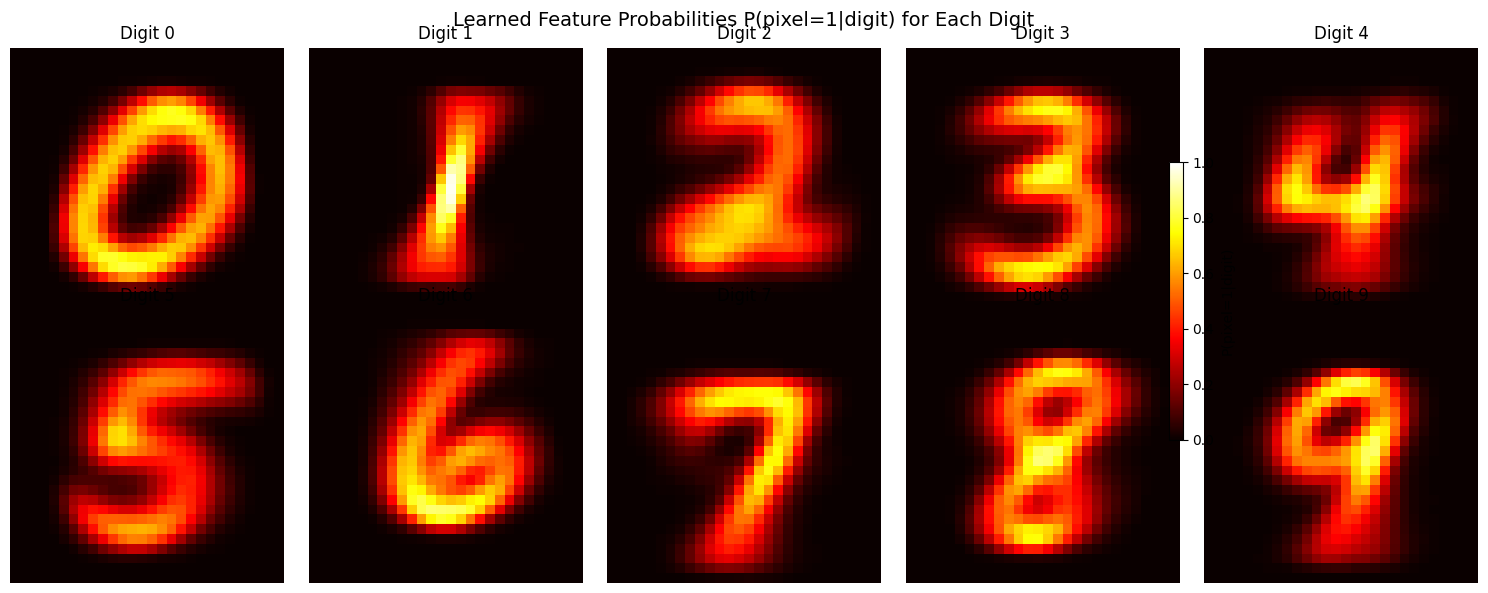

In [65]:
# Visualize learned probabilities for each digit
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Learned Feature Probabilities P(pixel=1|digit) for Each Digit', fontsize=14)

for idx, digit in enumerate(nb_classifier.classes):
    ax = axes[idx // 5, idx % 5]
    
    # Reshape probabilities back to 28x28 image
    prob_image = nb_classifier.feature_probs[idx].reshape(28, 28)
    
    # Display as heatmap
    im = ax.imshow(prob_image, cmap='hot', vmin=0, vmax=1)
    ax.set_title(f'Digit {digit}')
    ax.axis('off')

plt.colorbar(im, ax=axes.ravel().tolist(), label='P(pixel=1|digit)', shrink=0.6)
plt.tight_layout()
plt.show()

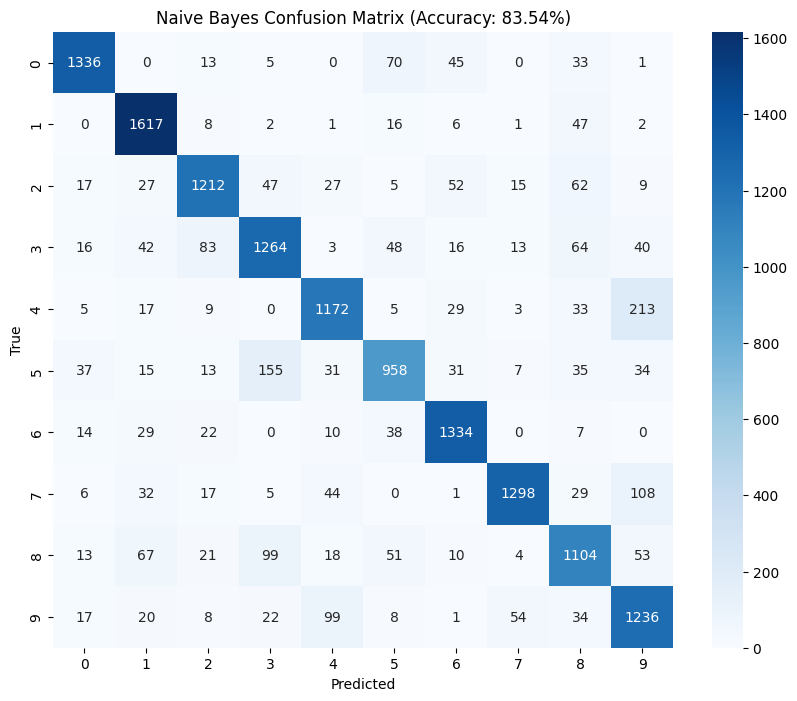

In [67]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm_nb = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Naive Bayes Confusion Matrix (Accuracy: {nb_accuracy:.2%})')
plt.show()

### NumPy Implementation

Manual implementation with forward pass, backward pass, and gradient descent updates.


Weight init can be optimized for Sigmoid activation function using [xavier initilaztion](https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/)





In [ ]:
class LinearClassifierNumPy:
    def __init__(self, n_features, n_classes, learning_rate=0.01, normalized_xavier_init= False):
        """
        Args:
            n_features: Number of input features
            n_classes: Number of output classes
            learning_rate: Step size for gradient descent
            normalized_xavier_init: Optional initialtion technique for better optimization
        """
        self.n_features = n_features
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        
        if normalized_xavier_init:
            limit = np.sqrt(6 / (n_features + n_classes))
            self.W = np.random.uniform(-limit, limit, (n_classes, n_features))
            
        else:
            self.W = np.random.uniform(-0.5,0.5, (n_classes, n_features))
        
        self.b = np.zeros((n_classes, 1))

    def _one_hot_encode(self, y):
        """Convert class labels to one-hot vectors"""
        n_samples = y.shape[0]
        y_one_hot = np.zeros((n_samples, self.n_classes))
        y_one_hot[np.arange(n_samples), y] = 1
        return y_one_hot
    
    def forward(self, X):
        # y = Wx + b
        # X shape: (n_samples, n_features)
        # W shape: (n_classes, n_features)
        # Result: (n_samples, n_classes)
        return np.matmul(X, self.W.T) + self.b.T
    
    def compute_loss(self, y_pred, y_true):
        #L2 Loss
        return np.sum((y_true - y_pred) ** 2)
    
    def backward(self, X, y_pred, y_true):
        n_samples = X.shape[0]
        
        d_loss = (y_pred - y_true) / n_samples  # Shape: (n_samples, n_classes)
        
        # Gradient w.r.t. W: dL/dW = (dL/dy) * (dy/dW) = d_loss.T @ X
        dW = np.matmul(d_loss.T, X)  # Shape: (n_classes, n_features)
        
        # Gradient w.r.t. b: dL/db = sum(dL/dy) over samples
        db = np.sum(d_loss, axis=0, keepdims=True).T  # Shape: (n_classes, 1)
        
        return dW, db
    
    def update_weights(self, dW, db):
        self.W -= self.learning_rate * dW
        self.b -= self.learning_rate * db
    
    def fit(self, X_train, y_train, epochs=100, batch_size=64, verbose=True):
        n_samples = X_train.shape[0]
        y_train_one_hot = self._one_hot_encode(y_train)

        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train_one_hot[indices]
            
            epoch_loss = 0
            n_batches = 0
            
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                 
                y_pred = self.forward(X_batch)
                
                loss = self.compute_loss(y_pred, y_batch)

                epoch_loss += loss
                n_batches += 1
                
                dW, db = self.backward(X_batch, y_pred, y_batch)
                
                self.update_weights(dW, db)

            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                avg_loss = epoch_loss / n_batches
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    def predict(self, X):
        logits = self.forward(X)
        return np.argmax(logits, axis=1)

In [109]:
linear_np = LinearClassifierNumPy(n_features=784, n_classes=10, learning_rate=0.01, normalized_xavier_init=True)
linear_np.fit(x_train, y_train, epochs=100, batch_size=16, verbose=True)


linear_np_predictions = linear_np.predict(x_test)
linear_np_accuracy = np.mean(linear_np_predictions == y_test)


print(f"\nLinear Classifier (NumPy) Accuracy: {linear_np_accuracy*100:.2f}%")

Epoch 1/100, Loss: 8.6766
Epoch 11/100, Loss: 6.3594
Epoch 21/100, Loss: 6.3112
Epoch 31/100, Loss: 6.2957
Epoch 41/100, Loss: 6.2853
Epoch 51/100, Loss: 6.2817
Epoch 61/100, Loss: 6.2844
Epoch 71/100, Loss: 6.2765
Epoch 81/100, Loss: 6.2769
Epoch 91/100, Loss: 6.2755
Epoch 100/100, Loss: 6.2740

Linear Classifier (NumPy) Accuracy: 84.29%


### PyTorch Implementation

Using PyTorch's built-in `nn.Linear`, autograd, and optimizer for automatic gradient computation.

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class LinearClassifierPyTorch(nn.Module):
    """
    Linear classifier using PyTorch
    Model: y = Wx + b
    Loss: MSE (Mean Squared Error)
    """
    
    def __init__(self, n_features, n_classes):
        """
        Args:
            n_features: Number of input features (784 for MNIST)
            n_classes: Number of output classes (10 for digits)
        """
        super(LinearClassifierPyTorch, self).__init__()
        self.linear = nn.Linear(n_features, n_classes)
        self.n_classes = n_classes
        
        # Better weight initialization to prevent NaN
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
        
    def forward(self, x):
        """
        Forward pass
        Args:
            x: Input features, shape (batch_size, n_features)
        Returns:
            Output logits, shape (batch_size, n_classes)
        """
        return self.linear(x)
    
    def fit(self, X_train, y_train, epochs=100, batch_size=256, learning_rate=0.01, verbose=True):
        """
        Train the model
        Args:
            X_train: Training features, numpy array (n_samples, n_features)
            y_train: Training labels, numpy array (n_samples,)
            epochs: Number of training epochs
            batch_size: Batch size for mini-batch gradient descent
            learning_rate: Learning rate for optimizer
            verbose: Print training progress
        """
        # Check for NaN or Inf in input data
        if np.isnan(X_train).any() or np.isinf(X_train).any():
            raise ValueError("Training data contains NaN or Inf values!")
        
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X_train)
        y_tensor = torch.LongTensor(y_train)
        
        # Create one-hot encoded labels for MSE loss
        y_one_hot = torch.zeros(y_train.shape[0], self.n_classes)
        y_one_hot[torch.arange(y_train.shape[0]), y_tensor] = 1
        
        # Create DataLoader for batching
        dataset = TensorDataset(X_tensor, y_one_hot)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Define loss function and optimizer
        criterion = nn.MSELoss()  # L2 loss
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        
        # Training loop
        for epoch in range(epochs):
            epoch_loss = 0.0
            n_batches = 0
            
            for X_batch, y_batch in dataloader:
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.forward(X_batch)
                
                # Check for NaN in outputs
                if torch.isnan(outputs).any():
                    print(f"Warning: NaN detected in outputs at epoch {epoch+1}")
                    print(f"X_batch stats - min: {X_batch.min():.4f}, max: {X_batch.max():.4f}")
                    print(f"Weights stats - min: {self.linear.weight.min():.4f}, max: {self.linear.weight.max():.4f}")
                    break
                
                # Compute loss
                loss = criterion(outputs, y_batch)
                
                # Check for NaN in loss
                if torch.isnan(loss):
                    print(f"Warning: NaN loss at epoch {epoch+1}, stopping training")
                    break
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping to prevent explosion
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                
                # Update weights
                optimizer.step()
                
                epoch_loss += loss.item()
                n_batches += 1
            
            # Print progress
            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                if n_batches > 0:
                    avg_loss = epoch_loss / n_batches
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    def predict(self, X):
        """
        Predict class labels
        Args:
            X: Input features, numpy array (n_samples, n_features)
        Returns:
            Predicted class labels, numpy array (n_samples,)
        """
        self.eval()  # Set to evaluation mode
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            outputs = self.forward(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
        return predictions.numpy()

In [72]:
# Train PyTorch Linear Classifier
print("=" * 50)
print("Training Linear Classifier (PyTorch Implementation)")
print("=" * 50)

# Check for NaN or Inf in data
print(f"Train data - NaN: {np.isnan(x_train).any()}, Inf: {np.isinf(x_train).any()}")
print(f"Train data - Min: {x_train.min():.4f}, Max: {x_train.max():.4f}")

linear_pt = LinearClassifierPyTorch(n_features=784, n_classes=10)
# Reduce learning rate to prevent NaN (0.01 instead of 0.1)
linear_pt.fit(x_train, y_train, epochs=100, batch_size=256, learning_rate=0.01, verbose=True)

# Evaluate
linear_pt_predictions = linear_pt.predict(x_test)
linear_pt_accuracy = np.mean(linear_pt_predictions == y_test)
print(f"\nLinear Classifier (PyTorch) Accuracy: {linear_pt_accuracy*100:.2f}%")

Training Linear Classifier (PyTorch Implementation)
Train data - NaN: False, Inf: False
Train data - Min: 0.0000, Max: 1.0000
Epoch 1/100, Loss: 0.1581
Epoch 11/100, Loss: 0.0615
Epoch 21/100, Loss: 0.0534
Epoch 31/100, Loss: 0.0499
Epoch 41/100, Loss: 0.0477
Epoch 51/100, Loss: 0.0463
Epoch 61/100, Loss: 0.0452
Epoch 71/100, Loss: 0.0444
Epoch 81/100, Loss: 0.0437
Epoch 91/100, Loss: 0.0432
Epoch 100/100, Loss: 0.0428

Linear Classifier (PyTorch) Accuracy: 84.21%


## Multilayer Perceptron (MLP) Implementation

A Multilayer Perceptron adds **hidden layers** with **nonlinear activation functions** between input and output, allowing it to learn complex, non-linear decision boundaries.

**Architecture**: 784 (input) → 256 (hidden) → 128 (hidden) → 10 (output)

**Key components:**
- Hidden layers with ReLU activation: $f(x) = \max(0, x)$
- SGD optimizer for weight updates
- Cross-entropy loss (better for classification than MSE)

In [73]:
class MLPClassifier(nn.Module):
    """
    Multilayer Perceptron (MLP) classifier with hidden layers and ReLU activation.
    Architecture: 784 → 256 → 128 → 10
    """
    
    def __init__(self, input_size=784, hidden_sizes=[256, 128], n_classes=10, dropout_rate=0.2):
        """
        Args:
            input_size: Number of input features (784 for MNIST)
            hidden_sizes: List of hidden layer sizes [256, 128]
            n_classes: Number of output classes (10 for digits)
            dropout_rate: Dropout probability for regularization
        """
        super(MLPClassifier, self).__init__()
        
        self.n_classes = n_classes
        
        # Build layers dynamically based on hidden_sizes
        layers = []
        prev_size = input_size
        
        # Hidden layers with ReLU and Dropout
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output layer (no activation, we'll use CrossEntropyLoss which includes softmax)
        layers.append(nn.Linear(prev_size, n_classes))
        
        # Combine all layers into a sequential model
        self.network = nn.Sequential(*layers)
        
        # Initialize weights with Xavier initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Xavier initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """
        Forward pass through the network
        Args:
            x: Input features, shape (batch_size, input_size)
        Returns:
            Output logits, shape (batch_size, n_classes)
        """
        return self.network(x)
    
    def fit(self, X_train, y_train, epochs=50, batch_size=256, learning_rate=0.01, 
            X_val=None, y_val=None, verbose=True):
        """
        Train the MLP model
        Args:
            X_train: Training features, numpy array (n_samples, n_features)
            y_train: Training labels, numpy array (n_samples,)
            epochs: Number of training epochs
            batch_size: Batch size for mini-batch SGD
            learning_rate: Learning rate for SGD optimizer
            X_val: Validation features (optional)
            y_val: Validation labels (optional)
            verbose: Print training progress
        """
        # Check for NaN or Inf in input data
        if np.isnan(X_train).any() or np.isinf(X_train).any():
            raise ValueError("Training data contains NaN or Inf values!")
        
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X_train)
        y_tensor = torch.LongTensor(y_train)
        
        # Create DataLoader for batching
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()  # Better for classification than MSE
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        
        # Training loop
        for epoch in range(epochs):
            self.train()  # Set to training mode (enables dropout)
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for X_batch, y_batch in dataloader:
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.forward(X_batch)
                
                # Compute loss
                loss = criterion(outputs, y_batch)
                
                # Check for NaN in loss
                if torch.isnan(loss):
                    print(f"Warning: NaN loss at epoch {epoch+1}, stopping training")
                    return
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping to prevent explosion
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                
                # Update weights
                optimizer.step()
                
                # Track statistics
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
            
            # Calculate training accuracy
            train_acc = 100 * correct / total
            avg_loss = epoch_loss / len(dataloader)
            
            # Validation accuracy (if validation set provided)
            val_acc = None
            if X_val is not None and y_val is not None:
                val_acc = self._evaluate(X_val, y_val) * 100
            
            # Print progress
            if verbose and (epoch % 5 == 0 or epoch == epochs - 1):
                if val_acc is not None:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
                          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
                else:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
                          f"Train Acc: {train_acc:.2f}%")
    
    def _evaluate(self, X, y):
        """Helper function to evaluate accuracy"""
        self.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.LongTensor(y)
            outputs = self.forward(X_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_tensor).sum().item() / y_tensor.size(0)
        return accuracy
    
    def predict(self, X):
        """
        Predict class labels
        Args:
            X: Input features, numpy array (n_samples, n_features)
        Returns:
            Predicted class labels, numpy array (n_samples,)
        """
        self.eval()  # Set to evaluation mode (disables dropout)
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            outputs = self.forward(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
        return predictions.numpy()

In [82]:

val_size = int(0.1 * x_train.shape[0])
X_train_mlp = x_train[:-val_size]
y_train_mlp = y_train[:-val_size]
X_val_mlp = x_train[-val_size:]
y_val_mlp = y_train[-val_size:]

print(f"Training samples: {X_train_mlp.shape[0]}")
print(f"Validation samples: {X_val_mlp.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")

# Create and train MLP with architecture: 784 → 256 → 128 → 10
mlp = MLPClassifier(input_size=784, hidden_sizes=[256, 128], n_classes=10, dropout_rate=0.2)
mlp.fit(X_train_mlp, y_train_mlp, 
        epochs=50, 
        batch_size=256, 
        learning_rate=0.01,
        X_val=X_val_mlp,
        y_val=y_val_mlp,
        verbose=True)

# Evaluate on test set
mlp_predictions = mlp.predict(x_test)
mlp_accuracy = np.mean(mlp_predictions == y_test)
print(f"\nMLP Classifier Test Accuracy: {mlp_accuracy*100:.2f}%")

Training samples: 40500
Validation samples: 4500
Test samples: 15000
Epoch 1/50, Loss: 0.8858, Train Acc: 72.93%, Val Acc: 88.96%
Epoch 6/50, Loss: 0.2124, Train Acc: 93.82%, Val Acc: 94.38%


KeyboardInterrupt: 

## Convolutional Neural Network (CNN) Implementation

A **Convolutional Neural Network** uses convolutional layers to automatically learn spatial features from images, making it highly effective for computer vision tasks.

**Architecture**: 
- Conv Layer 1: 1→32 filters (3×3) + ReLU + MaxPool(2×2)
- Conv Layer 2: 32→64 filters (3×3) + ReLU + MaxPool(2×2)
- Fully Connected Layer: Flattened features → 128 → 10 classes

**Key advantages over MLP:**
- **Parameter efficiency**: Shared weights in convolutional filters
- **Translation invariance**: Detects features regardless of position
- **Spatial hierarchy**: Early layers detect edges, later layers detect complex patterns

In [78]:
class CNNClassifier(nn.Module):
    """
    Convolutional Neural Network for MNIST classification.
    Architecture: Conv(1→32) → ReLU → MaxPool → Conv(32→64) → ReLU → MaxPool → FC(128) → Output(10)
    """
    
    def __init__(self, n_classes=10, dropout_rate=0.5):
        """
        Args:
            n_classes: Number of output classes (10 for digits)
            dropout_rate: Dropout probability for regularization
        """
        super(CNNClassifier, self).__init__()
        
        self.n_classes = n_classes
        
        # Convolutional layers
        # Input: 1×28×28 (grayscale MNIST images)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # After conv1: 32×28×28
        # After pool1: 32×14×14
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # After conv2: 64×14×14
        # After pool2: 64×7×7
        
        # Pooling layer (will be reused)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # Flattened size: 64 * 7 * 7 = 3136
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, n_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """
        Forward pass through the network
        Args:
            x: Input images, shape (batch_size, 1, 28, 28)
        Returns:
            Output logits, shape (batch_size, n_classes)
        """
        # First convolutional block
        x = self.conv1(x)           # (batch, 32, 28, 28)
        x = torch.relu(x)           # ReLU activation
        x = self.pool(x)            # (batch, 32, 14, 14)
        
        # Second convolutional block
        x = self.conv2(x)           # (batch, 64, 14, 14)
        x = torch.relu(x)           # ReLU activation
        x = self.pool(x)            # (batch, 64, 7, 7)
        
        # Flatten for fully connected layers
        x = x.view(-1, 64 * 7 * 7)  # (batch, 3136)
        
        # Fully connected layers
        x = self.fc1(x)             # (batch, 128)
        x = torch.relu(x)           # ReLU activation
        x = self.dropout(x)         # Dropout for regularization
        x = self.fc2(x)             # (batch, n_classes)
        
        return x
    
    def fit(self, X_train, y_train, epochs=20, batch_size=128, learning_rate=0.001, 
            X_val=None, y_val=None, verbose=True):
        """
        Train the CNN model
        Args:
            X_train: Training features, numpy array (n_samples, n_features) - will be reshaped to (n, 1, 28, 28)
            y_train: Training labels, numpy array (n_samples,)
            epochs: Number of training epochs
            batch_size: Batch size for mini-batch SGD
            learning_rate: Learning rate for Adam optimizer
            X_val: Validation features (optional)
            y_val: Validation labels (optional)
            verbose: Print training progress
        """
        # Check for NaN or Inf in input data
        if np.isnan(X_train).any() or np.isinf(X_train).any():
            raise ValueError("Training data contains NaN or Inf values!")
        
        # Reshape flat images to 2D: (n_samples, 784) → (n_samples, 1, 28, 28)
        X_train_reshaped = X_train.reshape(-1, 1, 28, 28)
        
        # Convert to PyTorch tensors
        X_tensor = torch.FloatTensor(X_train_reshaped)
        y_tensor = torch.LongTensor(y_train)
        
        # Create DataLoader for batching
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        # Training loop
        for epoch in range(epochs):
            self.train()  # Set to training mode
            epoch_loss = 0.0
            correct = 0
            total = 0
            
            for X_batch, y_batch in dataloader:
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.forward(X_batch)
                
                # Compute loss
                loss = criterion(outputs, y_batch)
                
                # Check for NaN in loss
                if torch.isnan(loss):
                    print(f"Warning: NaN loss at epoch {epoch+1}, stopping training")
                    return
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                
                # Update weights
                optimizer.step()
                
                # Track statistics
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
            
            # Calculate training accuracy
            train_acc = 100 * correct / total
            avg_loss = epoch_loss / len(dataloader)
            
            # Validation accuracy (if validation set provided)
            val_acc = None
            if X_val is not None and y_val is not None:
                val_acc = self._evaluate(X_val, y_val) * 100
            
            # Print progress
            if verbose and (epoch % 2 == 0 or epoch == epochs - 1):
                if val_acc is not None:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
                          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
                else:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
                          f"Train Acc: {train_acc:.2f}%")
    
    def _evaluate(self, X, y):
        """Helper function to evaluate accuracy"""
        self.eval()
        X_reshaped = X.reshape(-1, 1, 28, 28)
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_reshaped)
            y_tensor = torch.LongTensor(y)
            outputs = self.forward(X_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_tensor).sum().item() / y_tensor.size(0)
        return accuracy
    
    def predict(self, X):
        """
        Predict class labels
        Args:
            X: Input features, numpy array (n_samples, 784)
        Returns:
            Predicted class labels, numpy array (n_samples,)
        """
        self.eval()  # Set to evaluation mode
        X_reshaped = X.reshape(-1, 1, 28, 28)
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_reshaped)
            outputs = self.forward(X_tensor)
            predictions = torch.argmax(outputs, dim=1)
        return predictions.numpy()